<a href="https://colab.research.google.com/github/jeniferwerthman/AdvAILSTM/blob/main/Copy_of_LSTMStock_Take2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
!pip install -q yfinance

In [80]:
import pandas as pd
import pandas_datareader as pdr
from pandas_datareader.data import DataReader
import yfinance as yf
import matplotlib.pyplot as mplot
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates
import numpy as np
import altair as alt  
from datetime import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

In [82]:
#Import Data 
stockTypes = ['TSLA','AAPL', 'GOOG', 'MSFT', 'AMZN']

#Import from file
#stockDf = pd.read_csv('AAPL.csv',delimiter=',') 

#Import from API
end = dt.now()
start = dt(end.year - 2, end.month, end.day)
for stockDf in stockTypes:
    globals()[stockDf] = yf.download(stockDf, start, end)

#Add Name
stocks = [TSLA, AAPL, GOOG, MSFT, AMZN]
company_name = ["TESLA", "APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for stock, name in zip(stocks, company_name):
    stock["company_name"] = name

#Additional Columns
for stock in stocks:
    stock['openChange'] = stock.Open.pct_change()
    stock['closeChange'] = stock.Close.pct_change()
    #stock['month'] = pd.DatetimeIndex(stock['Date']).month
    #stock['day'] = pd.DatetimeIndex(stock['Date']).day
    #stock['year'] = pd.DatetimeIndex(stock['Date']).year
    #stock['display'] = stock["month"].map(str)+ "-" + stock["year"].map(str)

# Select features (columns) to be involved intro training and predictions
cols = list(stocks[1])[0:1]
#cols.pop(1) #Delete middle column

print('Training set shape == {}'.format(stocks[1].shape))
print('Featured selected: {}'.format(cols))

print(AAPL[0:5])
#datelist_train = list(AAPL[0:1]
#datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train[0]]


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Training set shape == (504, 9)
Featured selected: ['Open']
                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2020-05-01  71.562500  74.750000  71.462502  72.267502  71.287926  240616800   
2020-05-04  72.292503  73.422501  71.580002  73.290001  72.296570  133568000   
2020-05-05  73.764999  75.250000  73.614998  74.389999  73.381653  147751200   
2020-05-06  75.114998  75.809998  74.717499  75.157501  74.138748  142333600   
2020-05-07  75.805000  76.292503  75.492500  75.934998  74.905708  115215200   

           company_name  openChange

In [83]:
TSLA.describe()

,Open,High,Low,Close,Adj Close,Volume,openChange,closeChange
count,504.000000,504.000000,504.000000,504.000000,504.000000,5.040000e+02,503.000000,503.000000
mean,669.433524,684.721975,652.685012,669.267264,669.267264,3.914690e+07,0.004520,0.004460
std,268.223125,274.117781,261.211209,267.376194,267.376194,2.633382e+07,0.043885,0.040724
min,140.199997,152.399994,136.608002,140.264008,140.264008,9.800600e+06,-0.156610,-0.210628
25%,441.630013,450.472504,428.724991,441.722504,441.722504,2.226932e+07,-0.017003,-0.018701
50%,684.620026,697.575012,669.174988,683.009979,683.009979,3.043895e+07,0.003116,0.002600
75%,855.029999,875.065002,837.804993,855.262497,855.262497,4.648222e+07,0.028053,0.024531
max,1234.410034,1243.489990,1217.000000,1229.910034,1229.910034,2.221262e+08,0.188395,0.196412


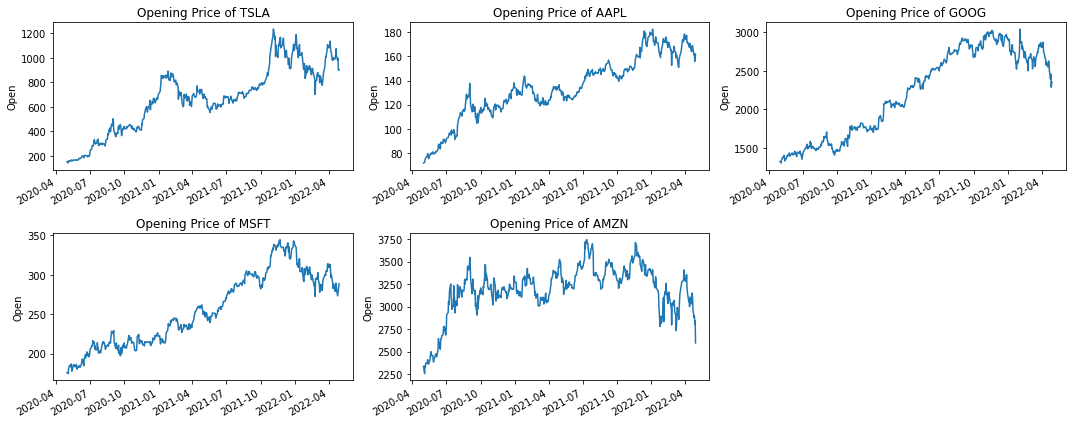

In [84]:
#Opening Graph
mplot.figure(figsize=(15, 6))
mplot.subplots_adjust(top=1.25, bottom=1)

for i, stock in enumerate(stocks, 1):
    mplot.subplot(2, 3, i)
    stock['Open'].plot()
    mplot.ylabel('Open')
    mplot.xlabel(None)
    mplot.title(f"Opening Price of {stockTypes[i - 1]}")
    
mplot.tight_layout()

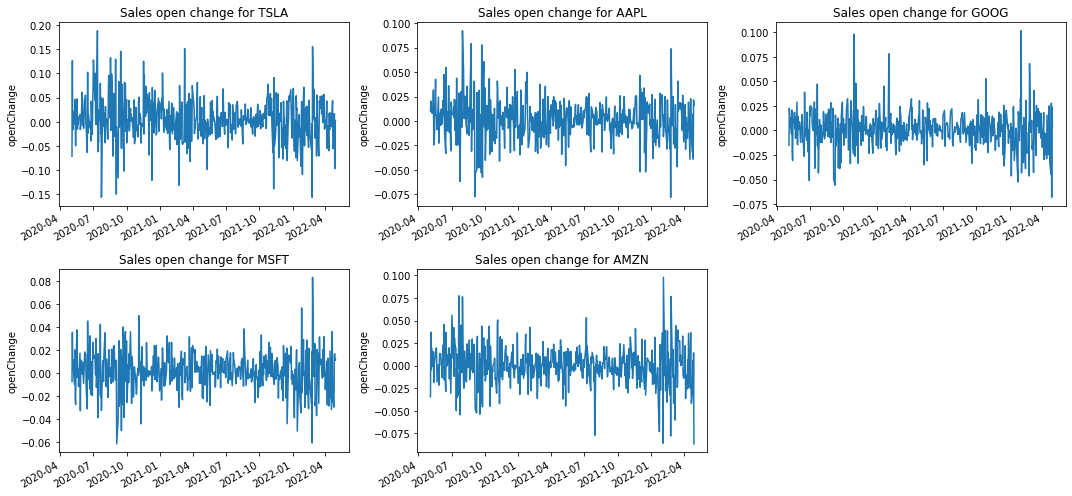

In [85]:
#Change Graphs

mplot.figure(figsize=(15, 7))
mplot.subplots_adjust(top=1.25, bottom=1.2)

for i, stock in enumerate(stocks, 1):
    mplot.subplot(2, 3, i)
    stock['openChange'].plot()
    mplot.ylabel('openChange')
    mplot.xlabel(None)
    mplot.title(f"Sales open change for {stockTypes[i - 1]}")
    
mplot.tight_layout()

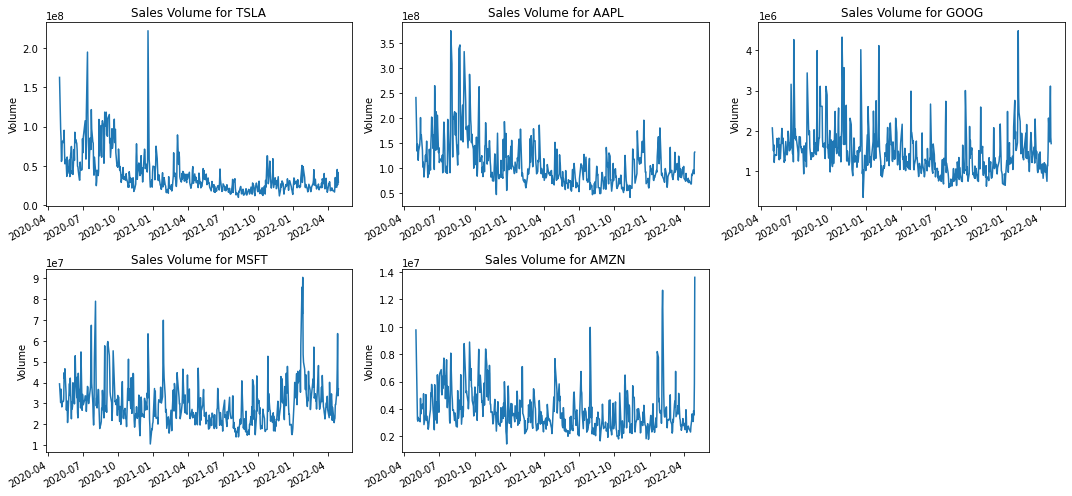

In [24]:
#Volume Graphs

mplot.figure(figsize=(15, 7))
mplot.subplots_adjust(top=1.25, bottom=1.2)

for i, stock in enumerate(stocks, 1):
    mplot.subplot(2, 3, i)
    stock['Volume'].plot()
    mplot.ylabel('Volume')
    mplot.xlabel(None)
    mplot.title(f"Sales Volume for {stockTypes[i - 1]}")
    
mplot.tight_layout()

In [205]:
#Get Desired columns to train
stockDf = stocks[1]
print('Featured selected: {}'.format(cols))
stockDf = stockDf[cols].astype(str)
for i in cols:
    for j in range(0, len(stockDf)):
        stockDf[i][j] = stockDf[i][j].replace(',', '')

stockDf = stockDf.astype(float)

# Using multiple features (predictors) 
fromRecord = 50
toRecord = 100
#newDf = stockDf.loc[fromRecord:toRecord] 
newDf = stockDf[fromRecord:toRecord]
myDs = newDf.to_numpy() 
myDs = myDs.astype('float32')
print('Shape of training set == {}.'.format(newDf.shape))
newDf[1:5]

Featured selected: ['Open']
Shape of training set == (50, 1).


,Open
Date,
2020-07-15,98.989998
2020-07-16,96.562500
2020-07-17,96.987503
2020-07-20,96.417503


In [206]:
#Parameters
trainingSet = .70
featureRange1 = 0
featureRange2 = 1
newShape1 = -1
newShape2 = 1 

myDs = np.reshape(myDs, (newShape1, newShape2))
scaler = MinMaxScaler(feature_range=(featureRange1, featureRange2))
myDs = scaler.fit_transform(myDs)
trainingSize = int(len(myDs) * trainingSet)
testingSize = int(len(myDs) - trainingSize)
trainData, testData = myDs[0:trainingSize,:], myDs[testingSize:len(myDs),:]


In [207]:
#Parameters
batchSize = 5
timeSteps = 1
#Batch Data for optimization and accuracy
#This creates batches with 1 to N records.  
#X - Each Batch starts with the next item i in the list and contains specified number of additional items
#Y - Contains the last item in each batch "L" or first "F" or previious "P" or next "N"
def batchData(data, size, indexAlignment = "L"):
    X, Y = [], [] 
    for i in range(len(data) - size - 1): 
        X.append(data[i:(i + size), 0])
         
        if indexAlignment == "N":
          Y.append(data[i + size, 0])
        elif indexAlignment == "L":
          Y.append(data[i + size - 1, 0])
        elif indexAlignment == "P":  
          Y.append(data[i-1, 0])
        else:
          Y.append(data[i, 0]) 

    return np.array(X), np.array(Y)

#Catch Batches for Accuracy and Optimization
X_train, Y_train = batchData(trainData, batchSize, "L")
X_test, Y_test = batchData(testData, batchSize,"L")

#Reshape data to normalize it [samples, time steps, features]
print("take 1")
print('X_Train[0] (Samples): ' + str(X_train.shape[0]))
print('X_Train[1] (Features): ' + str(X_train.shape[1]))
X_train = np.reshape(X_train, (X_train.shape[0], timeSteps, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], timeSteps, X_test.shape[1]))
print("take 2")
print('X_Train[0] (Samples): ' + str(X_train.shape[0]))
print('X_Train[1] (Features): ' + str(X_train.shape[1]))

take 1
X_Train[0] (Samples): 29
X_Train[1] (Features): 5
take 2
X_Train[0] (Samples): 29
X_Train[1] (Features): 1


In [208]:
#Parameters
verboseAmt = 1
epochCnt = 100
shuffleData = False
dropOut = 0.2
lstmActivation = 'relu'
activationLayer = 'linear'
lossType = 'mean_squared_error'
optimizerType = 'adam'
lstmUnits = 50
lstmMultipleLayers = True

model = Sequential()

if lstmMultipleLayers:
  model.add(LSTM(units = lstmUnits, return_sequences = True, activation = lstmActivation, input_shape = (X_train.shape[1], batchSize)))
  model.add(Dropout(dropOut))

  model.add(LSTM(units = lstmUnits, return_sequences = True))
  model.add(Dropout(dropOut))

  model.add(LSTM(units = lstmUnits, return_sequences = True))
  model.add(Dropout(dropOut))

  model.add(LSTM(units = lstmUnits))
  model.add(Dropout(dropOut))
else:
  model.add(LSTM(units = lstmUnits, activation = lstmActivation, input_shape = (X_train.shape[1], batchSize))) 
  model.add(Dropout(dropOut))

model.add(Dense(1, activation = activationLayer))
model.compile(loss = lossType, optimizer = optimizerType)
modelFit = model.fit(X_train, Y_train, epochs = epochCnt, batch_size = batchSize, validation_data = (X_test, Y_test), verbose = verboseAmt, shuffle = False)
model.summary()

Epoch 1/100
6/6 [==============================] - 18s 362ms/step - loss: 0.1960 - val_loss: 0.3654
Epoch 2/100
6/6 [==============================] - 0s 14ms/step - loss: 0.1802 - val_loss: 0.3396
Epoch 3/100
6/6 [==============================] - 0s 17ms/step - loss: 0.1637 - val_loss: 0.3100
Epoch 4/100
6/6 [==============================] - 0s 15ms/step - loss: 0.1430 - val_loss: 0.2753
Epoch 5/100
6/6 [==============================] - 0s 16ms/step - loss: 0.1247 - val_loss: 0.2337
Epoch 6/100
6/6 [==============================] - 0s 16ms/step - loss: 0.0964 - val_loss: 0.1840
Epoch 7/100
6/6 [==============================] - 0s 14ms/step - loss: 0.0721 - val_loss: 0.1276
Epoch 8/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0512 - val_loss: 0.0712
Epoch 9/100
6/6 [==============================] - 0s 16ms/step - loss: 0.0257 - val_loss: 0.0294
Epoch 10/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0339 - val_loss: 0.0146
Epoch 11/100
6/6 

In [209]:
#Predictions
train_predict = model.predict(X_train)
Y_trained_predict = scaler.inverse_transform(train_predict)

test_predict = model.predict(X_test)
Y_test_predict = scaler.inverse_transform(test_predict)

Y_test = scaler.inverse_transform([Y_test])
Y_train = scaler.inverse_transform([Y_train])

In [210]:
print('X_train: ' + str(len(X_train)))
print('X_test: ' + str(len(X_test)))
print('Y_train: ' + str(len(Y_train)))
print('Y_test: ' + str(len(Y_test)))
print('X Train Shape' + str(X_train.shape))
print('Y Train Shape' + str(Y_train.shape))
print('X Test Shape' + str(X_test.shape))
print('Y Test Shape' + str(Y_test.shape))
print('train_predict: ' + str(len(train_predict)))
print('Y_trained_predict: ' + str(len(Y_trained_predict)))
print('test_predict: ' + str(len(test_predict)))
print('Y_test_predict: ' + str(len(Y_test_predict)))
print('Shape of Y_train:'  + str(Y_train.shape[0]))
print('Shape of Y_train:' + str(Y_train.shape[0]))
print('Shape of Y_train:'  + str(Y_train.shape[0]))
print('Shape of Y_train:'  + str(Y_train.shape[0]))

X_train: 29
X_test: 29
Y_train: 1
Y_test: 1
X Train Shape(29, 1, 5)
Y Train Shape(1, 29)
X Test Shape(29, 1, 5)
Y Test Shape(1, 29)
train_predict: 29
Y_trained_predict: 29
test_predict: 29
Y_test_predict: 29
Shape of Y_train:1
Shape of Y_train:1
Shape of Y_train:1
Shape of Y_train:1


In [211]:
#inverse the inverse
Y_trained_predict = scaler.inverse_transform(train_predict)
Y_test_predict = scaler.inverse_transform(test_predict)

s1 = Y_test.shape[0]
s2 = Y_test.shape[1]
Y_test = Y_test.reshape(s2,s1)
s1 = Y_train.shape[0]
s2 = Y_train.shape[1]
Y_train = Y_train.reshape(s2,s1)

In [212]:
#Calculate Accuracy
train_RMSE = np.sqrt(mean_squared_error(Y_train, Y_trained_predict))
test_RMSE = np.sqrt(mean_squared_error(Y_test, Y_test_predict))

print('Train RMSE is: ')
print(train_RMSE, '\n')
print('Test RMSE is: ')
print(test_RMSE)

Train RMSE is: 
2.570336148834631 

Test RMSE is: 
2.8881117019564444


In [213]:
#Actual vs Predicted Data
Y = np.append(Y_train, Y_test)
Y_hat = np.append(Y_trained_predict, Y_test_predict)
result_df = pd.DataFrame()
result_df['Actual_Y'] = Y
result_df['Predicted_Y'] = Y_hat
result_df.head()

,Actual_Y,Predicted_Y
0,96.417500,96.725471
1,99.172504,97.760384
2,96.692495,97.380325
3,96.997500,97.105042
4,90.987504,94.853867


Text(0, 0.5, 'Value of Stock')

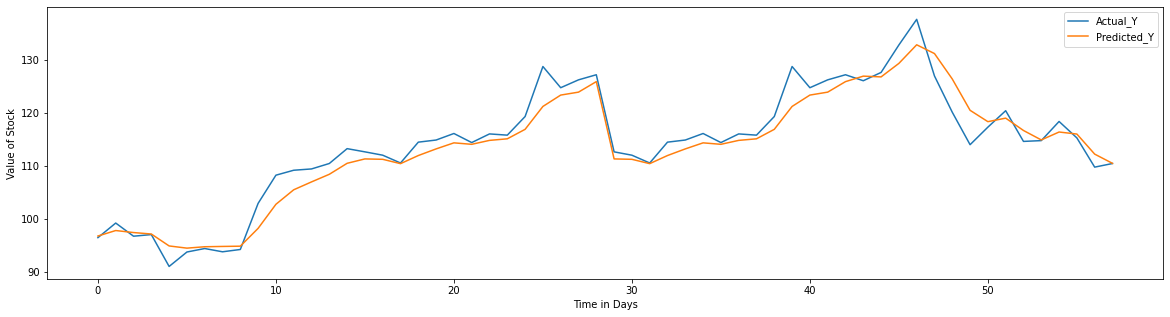

In [214]:
#Actual vs Predicted Graph
result_df.plot(figsize=(20,5))
mplot.xlabel('Time in Days')
mplot.ylabel('Value of Stock')

In [215]:
predictionCount = 9
datelist_future = pd.date_range(end, periods=predictionCount, freq='1d').tolist()

print(datelist_future)
lookback =15



[Timestamp('2022-05-01 20:34:54.525665', freq='D'), Timestamp('2022-05-02 20:34:54.525665', freq='D'), Timestamp('2022-05-03 20:34:54.525665', freq='D'), Timestamp('2022-05-04 20:34:54.525665', freq='D'), Timestamp('2022-05-05 20:34:54.525665', freq='D'), Timestamp('2022-05-06 20:34:54.525665', freq='D'), Timestamp('2022-05-07 20:34:54.525665', freq='D'), Timestamp('2022-05-08 20:34:54.525665', freq='D'), Timestamp('2022-05-09 20:34:54.525665', freq='D')]


In [216]:
#Run ME
from datetime import timedelta


#date calculation for past
n_days_ago = end - timedelta(days=lookback)
datelist_past = pd.date_range(n_days_ago, periods=lookback, freq='1d').tolist()

print(datelist_past)

predictMeData = stockDf[-lookback:] 
#print(predictMeData)
predictionDs = predictMeData.to_numpy() 
predictionDs = predictionDs.astype('float32')

predictionDs = np.reshape(predictionDs, (newShape1, newShape2))
scaler = MinMaxScaler(feature_range=(featureRange1, featureRange2))
predictionDs = scaler.fit_transform(predictionDs)  
X = predictionDs[0:lookback,:]
#print(X)
XX, YY = batchData(X, batchSize, "L")
XX = np.reshape(XX, (XX.shape[0], timeSteps, XX.shape[1]))
out = model.predict(XX)
#print(out)

Y_out = scaler.inverse_transform(out) 

#print(len(Y_out))
#print(Y_out)
#New code for future prediction
y_past_predict = model.predict(X_train[lookback-1:])
y_past_train = scaler.inverse_transform(y_past_predict)
#print(y_past_train)

y_future_predict = model.predict(X_train[-predictionCount:])
y_future_train = scaler.inverse_transform(y_future_predict)
#print(y_future_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_future_train, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_past_train, columns=['Open']).set_index(pd.Series(datelist_past))
print(PREDICTIONS_FUTURE)
print(PREDICTION_TRAIN)
PREDICTIONS_FUTURE.head(11)

[Timestamp('2022-04-16 20:34:54.525665', freq='D'), Timestamp('2022-04-17 20:34:54.525665', freq='D'), Timestamp('2022-04-18 20:34:54.525665', freq='D'), Timestamp('2022-04-19 20:34:54.525665', freq='D'), Timestamp('2022-04-20 20:34:54.525665', freq='D'), Timestamp('2022-04-21 20:34:54.525665', freq='D'), Timestamp('2022-04-22 20:34:54.525665', freq='D'), Timestamp('2022-04-23 20:34:54.525665', freq='D'), Timestamp('2022-04-24 20:34:54.525665', freq='D'), Timestamp('2022-04-25 20:34:54.525665', freq='D'), Timestamp('2022-04-26 20:34:54.525665', freq='D'), Timestamp('2022-04-27 20:34:54.525665', freq='D'), Timestamp('2022-04-28 20:34:54.525665', freq='D'), Timestamp('2022-04-29 20:34:54.525665', freq='D'), Timestamp('2022-04-30 20:34:54.525665', freq='D')]
                                  Open
2022-05-01 20:34:54.525665  163.848328
2022-05-02 20:34:54.525665  163.754227
2022-05-03 20:34:54.525665  164.006393
2022-05-04 20:34:54.525665  164.107864
2022-05-05 20:34:54.525665  164.716080


,Open
2022-05-01 20:34:54.525665,163.848328
2022-05-02 20:34:54.525665,163.754227
2022-05-03 20:34:54.525665,164.006393
2022-05-04 20:34:54.525665,164.107864
2022-05-05 20:34:54.525665,164.716080
2022-05-06 20:34:54.525665,166.186737
2022-05-07 20:34:54.525665,166.916428
2022-05-08 20:34:54.525665,167.105530
2022-05-09 20:34:54.525665,167.780212


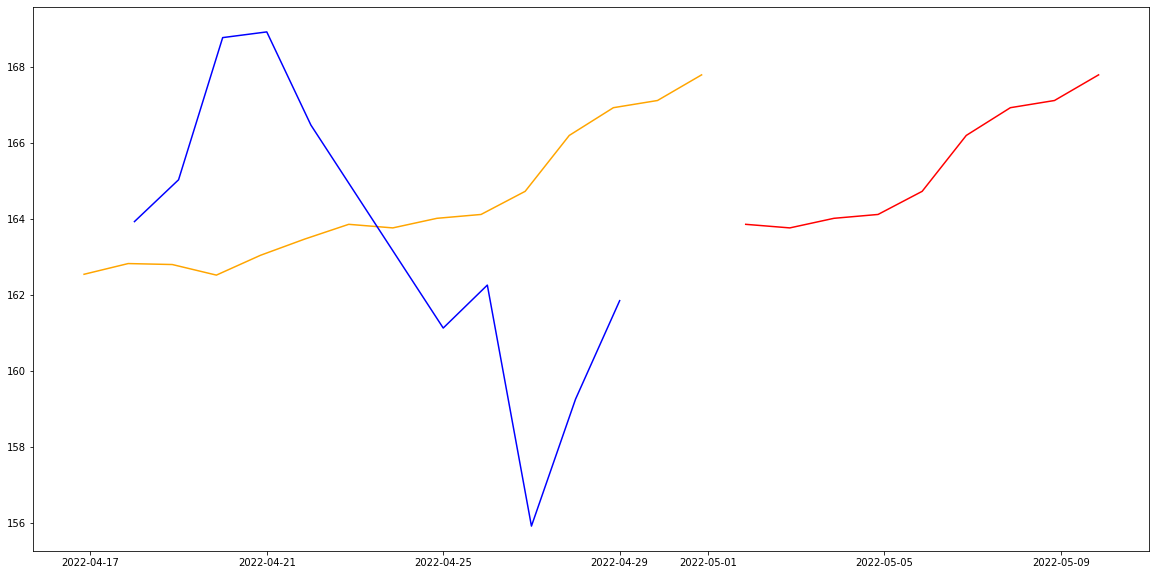

In [219]:
mplot.figure(figsize=(20,10))
mplot.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Open'], color='r', label='Predicted Stock Price')
mplot.plot(PREDICTION_TRAIN.loc[n_days_ago:].index, PREDICTION_TRAIN.loc[n_days_ago:]['Open'], color='orange', label='Training predictions')
mplot.plot(stockDf.loc[n_days_ago:].index, stockDf.loc[n_days_ago:]['Open'], color='b', label='Actual Stock Price')
mplot.show()